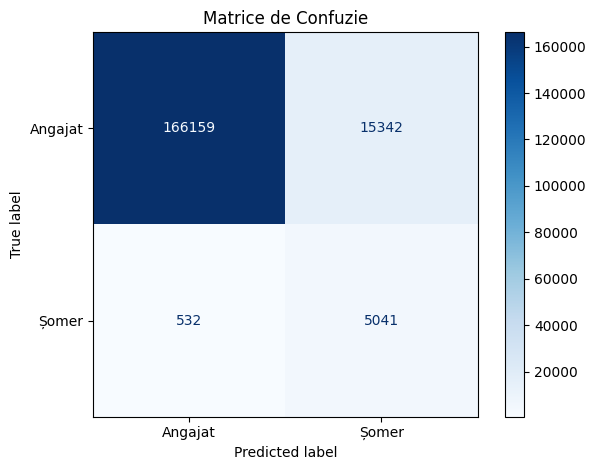

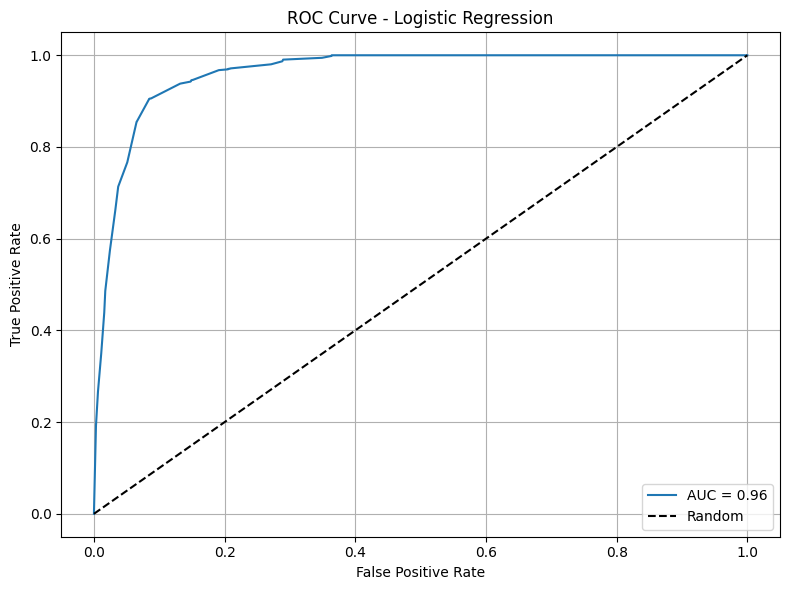

C:\Users\allpr\AppData\Local\Temp\ipykernel_10496\562468171.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, y='Feature', x='Coefficient', palette='magma')


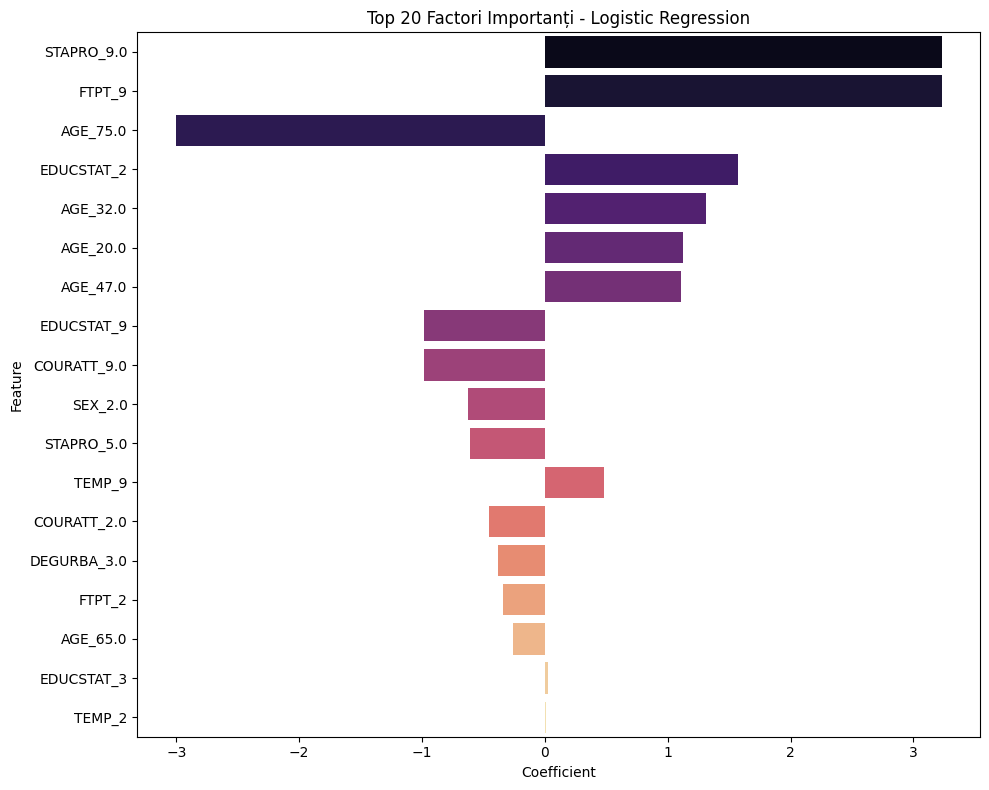

C:\Users\allpr\AppData\Local\Temp\ipykernel_10496\562468171.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


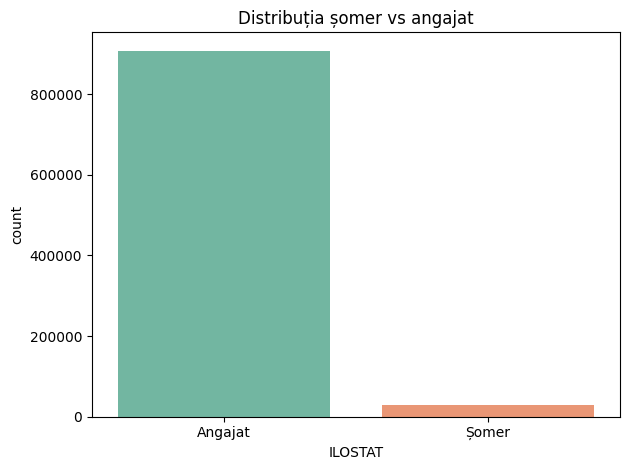

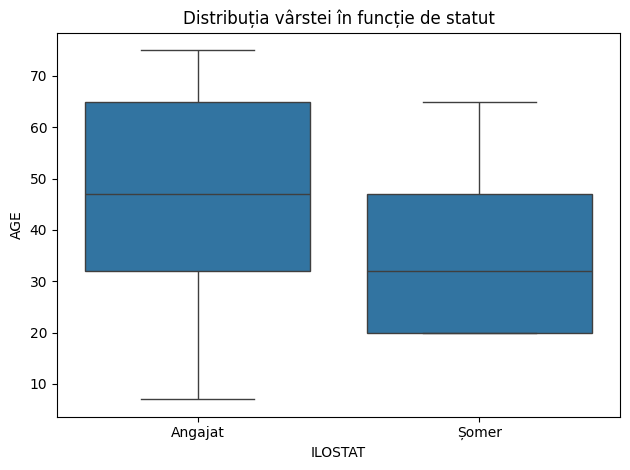

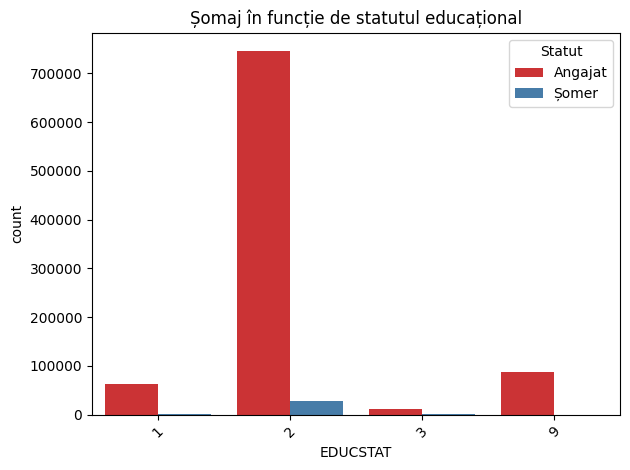

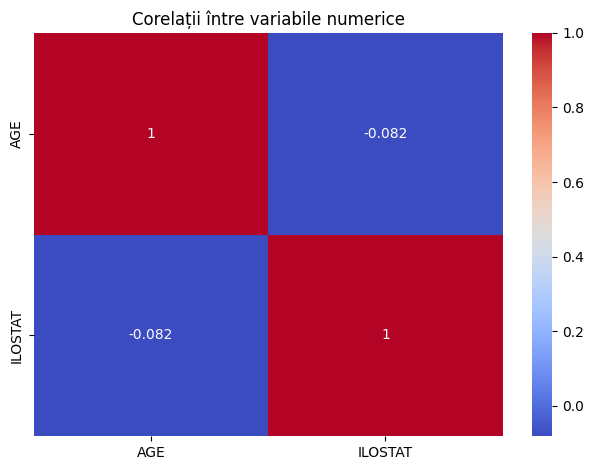


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.95    181501
           1       0.25      0.90      0.39      5573

    accuracy                           0.92    187074
   macro avg       0.62      0.91      0.67    187074
weighted avg       0.97      0.92      0.94    187074



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report
)

# === Încarcă datele pentru toți anii ===
dfs = []
for year in ['2010', '2011', '2012', '2013']:
    df = pd.read_csv(f"../data/raw/RO_LFS_{year}_Y.csv", low_memory=False)
    df['YEAR'] = int(year)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# === Selectează variabilele relevante ===
features = ['SEX', 'AGE', 'EDUCSTAT', 'DEGURBA', 'STAPRO', 'TEMP', 'FTPT', 'COURATT']
target = 'ILOSTAT'
data = data[features + [target]].copy()

# === Pregătește targetul binar ===
data = data[data[target].notna()]
data[target] = (data[target] == 2).astype(int)
data.dropna(subset=features + [target], inplace=True)

# === One-hot encoding ===
data_encoded = pd.get_dummies(data, columns=features, drop_first=True)

# === Train/Test split ===
X = data_encoded.drop(columns=[target])
y = data_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Normalizează ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Logistic Regression ===
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Angajat", "Șomer"])
disp.plot(cmap="Blues")
plt.title("Matrice de Confuzie")
plt.grid(False)
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Feature Importances ===
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df, y='Feature', x='Coefficient', palette='magma')
plt.title("Top 20 Factori Importanți - Logistic Regression")
plt.tight_layout()
plt.show()

# === Distribution of the Target ===
sns.countplot(x=y, palette='Set2')
plt.title("Distribuția șomer vs angajat")
plt.xticks([0, 1], ['Angajat', 'Șomer'])
plt.tight_layout()
plt.show()

# === Boxplot: Vârstă vs Șomaj ===
sns.boxplot(x=data['ILOSTAT'], y=data['AGE'])
plt.xticks([0, 1], ['Angajat', 'Șomer'])
plt.title("Distribuția vârstei în funcție de statut")
plt.tight_layout()
plt.show()

# === Countplot: EDUCAȚIE vs Șomaj ===
sns.countplot(data=data, x='EDUCSTAT', hue='ILOSTAT', palette='Set1')
plt.title("Șomaj în funcție de statutul educațional")
plt.legend(title="Statut", labels=['Angajat', 'Șomer'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Heatmap Corelații ===
corr = data[['AGE', 'ILOSTAT']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Corelații între variabile numerice")
plt.tight_layout()
plt.show()

# === Classification report ===
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
